THE CODE BELOW INTEGRATES THE HW4 STUFF AND ADDS THE WORK FROM ABOVE...

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import pickle

warnings.filterwarnings('ignore')
path = 'inputs/'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

# Add holidays
def insert_holidays(testy):
    data = testy.copy()
    data['nat_holiday'] = 0
    data['reg_holiday'] = 0
    data['loc_holiday'] = 0

    stores = stores_new.copy()
    holidays = pd.read_csv(path + 'holidays_events.csv',
                        usecols=['date', 'type', 'locale', 'locale_name', 'transferred'],
                        dtype={'type': 'category', 'locale': 'category', 'locale_name': 'category', 'transferred': 'bool'},
                        parse_dates=['date'], infer_datetime_format=True
                        )
    holidays = holidays.reset_index()
    stores = stores.reset_index()

    for index, row in holidays.iterrows():
        store_nbr_list = []
        if row['locale'] == 'Local':
            for sindex, srow in stores.iterrows():
                if srow['city'] == row['locale_name']:
                    data.loc[(data['date'] == row['date']) & (data['store_nbr'] == srow['store_nbr']), 'loc_holiday'] = 1
        if row['locale'] == 'Regional':
            for sindex, srow in stores.iterrows():
                if srow['state'] == row['locale_name']:
                    data.loc[(data['date'] == row['date']) & (data['store_nbr'] == srow['store_nbr']), 'reg_holiday'] = 1
        if row['locale'] == 'National':
            data.loc[data['date'] == row['date'], 'nat_holiday'] = 1

    return data


#Adapted from https://www.kaggle.com/code/enesdilsiz/time-series-forecasting-with-lightgbm
def random_noise(dataframe):
    x = np.random.normal(scale=1.5, size=(len(dataframe),))
    return x

# Data preprocessing functions
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store_nbr", "family"])['sales'].transform(
            lambda x: x.shift(lag))
        #+ random_noise(dataframe)
    return dataframe

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store_nbr", "family"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


# Loss Functions
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False


def rmsle_lgbm(y_pred, data):
    y_true = np.array(data.get_label())
    score = np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))
    return 'rmsle', score, False

# Plotting and post processing functions
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

In [ ]:

# Load Oil Data
data_oil = pd.read_csv(path + 'oil.csv', parse_dates=['date'], infer_datetime_format=True)
data_oil['dcoilwtico'].fillna(method='ffill', inplace=True)
data_oil['ma_oil'] = data_oil['dcoilwtico'].rolling(7).mean()
data_oil['ma_oil'].fillna(method='ffill', inplace=True)
calendar = pd.DataFrame()
calendar['date'] = pd.date_range('2013-01-01', '2017-08-31')
cally = pd.merge(calendar, data_oil, how='outer', on='date' )
cally.fillna(method='ffill', inplace=True)
calendar = cally.copy()    #1704 rows

# Load Stores
stores_new = pd.read_csv(path + 'stores.csv',
                         usecols=['store_nbr', 'city', 'state', 'type', 'cluster'],
                         dtype={'store_nbr': 'category', 'city': 'category', 'state': 'category', 'type': 'category', 'cluster': 'category'})

transactions = pd.read_csv(path + 'transactions.csv',
                          usecols=['store_nbr', 'date', 'transactions'],
                          dtype={'store_nbr': 'category', 'transactions': 'float32'},
                          parse_dates=['date'], infer_datetime_format=True)

df_train = pd.read_csv(path + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

train_oil = pd.merge(df_train, calendar, how='outer', on='date')
train_oil.sort_values(by=['family','store_nbr'], axis=0, inplace=True)
train_oil['ma_oil'].fillna(method='ffill', inplace=True)
train_oil['dcoilwtico'].fillna(method='ffill', inplace=True)
train_oil_trans = pd.merge(transactions, train_oil, how='outer', on =['store_nbr', 'date'])
# train_oil_trans = train_oil_trans[train_oil_trans['family'].notna()]
# tmp.sort_values(by=['store_nbr', 'sales'], axis=0, inplace=True)
# train_oil_trans[train_oil_trans['transactions'].isnull()]
train_oil_trans_stores = train_oil_trans.merge(stores_new, on='store_nbr')
train_oil_trans_stores_holiday = insert_holidays(train_oil_trans_stores)
# tmp = train_oil_trans_stores_holiday[train_oil_trans_stores_holiday.transactions.isnull()]
# tmp = tmp.loc[(tmp.nat_holiday != 1) & (tmp.reg_holiday != 1) & (tmp.loc_holiday != 1)]
# tmp
train_oil_trans_stores_holiday.transactions.fillna(0, inplace=True)
data = train_oil_trans_stores_holiday.copy()
del train_oil_trans_stores_holiday, train_oil_trans_stores, train_oil_trans, train_oil, data_oil, df_train, transactions, cally
data.sort_values(by=['store_nbr', 'family', 'date'], axis=0, inplace=True)
# data.family.nunique()

In [20]:
lags = [x for x in range(1,16)]

In [ ]:
data = lag_features(data, lags)

In [28]:

df = data.copy()
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['quarter_of_year'] = df.date.dt.quarter
df['week_of_year'] = df.date.dt.isocalendar().week
df['day_of_year'] = df.date.dt.dayofyear
df['day_of_month'] = df.date.dt.day
# df['day_of_week'] = df.date.dt.dayofweek
df["is_wknd"] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)
 # pd.DataFrame({"sales": df["sales"].values[0:10],
 #              "lag1": df["sales"].shift(1).values[0:10],
 #              "lag2": df["sales"].shift(2).values[0:10],
 #              "lag3": df["sales"].shift(3).values[0:10],
 #              "lag4": df["sales"].shift(4).values[0:10]})

In [17]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
df = data.copy()

In [18]:
df = roll_mean_features(df, [128, 365, 546])

In [21]:
df = ewm_features(df, alphas, lags)

In [34]:
# df = pd.get_dummies(df, columns=[ 'day_of_week', 'month'])

In [22]:
df = pd.get_dummies(df, columns=[ 'store_nbr', 'family', 'city', 'state'])

In [29]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [30]:
df.columns

Index(['date', 'transactions', 'sales', 'onpromotion', 'dcoilwtico', 'ma_oil', 'type', 'cluster', 'nat_holiday', 'reg_holiday',
       ...
       'state_Guayas', 'state_Imbabura', 'state_Loja', 'state_LosRios', 'state_Manabi', 'state_Pastaza', 'state_Pichincha', 'state_SantaElena', 'state_SantoDomingodelosTsachilas', 'state_Tungurahua'], dtype='object', length=229)

In [31]:

train = df.loc[(df.date < "2013-07-15"), :]
val = df.loc[(df.date >= "2013-07-15" ) & (df.date < "2017-07-31")]

cols = [col for col in train.columns if col not in ['date', 'sales', 'transactions' ]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((347490,), (347490, 226), (2624886,), (2624886, 226))

In [41]:
def rlsme(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    preds[np.where(preds < 0)] = 0
    loss_val = np.sum(np.square((np.log(1+preds) - np.log(1 + target)))) / n
    return np.sqrt(loss_val)


def lgbm_rlsme(preds, train_data):
    labels = train_data.get_label()
    loss = rlsme(preds, labels)
    return "RMSLE", loss, False

In [25]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [37]:
lgbtrain_smape = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval_smape = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain_smape, feature_name=cols)

lgbtrain_rlsme = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval_rlsme = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain_rlsme, feature_name=cols)


LightGBM -- Setup

In [39]:
model_smape = lgb.train(lgb_params, lgbtrain_smape,
                  valid_sets=[lgbtrain_smape, lgbval_smape],
                  num_boost_round=lgb_params['num_boost_round'],
                  callbacks=[lgb.early_stopping(stopping_rounds=200)],
                  feval=lgbm_smape,
                  verbose_eval=100)

pickle.dump(model_smape, open("models/lgbm_smape.dat",'wb'))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 37531.5	training's SMAPE: 131.575	valid_1's l2: 145641	valid_1's SMAPE: 104.701
[200]	training's l2: 24045.3	training's SMAPE: 122.007	valid_1's l2: 118274	valid_1's SMAPE: 88.0295
[300]	training's l2: 20913.6	training's SMAPE: 119.102	valid_1's l2: 117087	valid_1's SMAPE: 84.0761
[400]	training's l2: 19328.7	training's SMAPE: 118.261	valid_1's l2: 117435	valid_1's SMAPE: 110.41
Early stopping, best iteration is:
[297]	training's l2: 20985.7	training's SMAPE: 119.142	valid_1's l2: 117124	valid_1's SMAPE: 83.729


In [42]:
model_rlsme = lgb.train(lgb_params, lgbtrain_rlsme,
                  valid_sets=[lgbtrain_rlsme, lgbval_rlsme],
                  num_boost_round=lgb_params['num_boost_round'],
                  callbacks=[lgb.early_stopping(stopping_rounds=200)],
                  feval=lgbm_rlsme,
                  verbose_eval=100)

pickle.dump(model_rlsme, open("models/lgbm_rlsme.dat",'wb'))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 37531.5	training's RMSLE: 2.69139	valid_1's l2: 145641	valid_1's RMSLE: 2.18098
[200]	training's l2: 24045.3	training's RMSLE: 1.74079	valid_1's l2: 118274	valid_1's RMSLE: 1.36295
[300]	training's l2: 20913.6	training's RMSLE: 1.28521	valid_1's l2: 117087	valid_1's RMSLE: 1.00594
[400]	training's l2: 19328.7	training's RMSLE: 1.0566	valid_1's l2: 117435	valid_1's RMSLE: 1.07014
[500]	training's l2: 18185	training's RMSLE: 0.948596	valid_1's l2: 117422	valid_1's RMSLE: 1.08631
Early stopping, best iteration is:
[300]	training's l2: 20913.6	training's RMSLE: 1.28521	valid_1's l2: 117087	valid_1's RMSLE: 1.00594


In [43]:
y_pred_val_smape = model_smape.predict(X_val, num_iteration=model_smape.best_iteration)
y_pred_val_rlsme = model_rlsme.predict(X_val, num_iteration=model_rlsme.best_iteration)

In [45]:
# smape(y_pred_val, Y_val)
smape(y_pred_val_smape, Y_val)

83.72898817466971

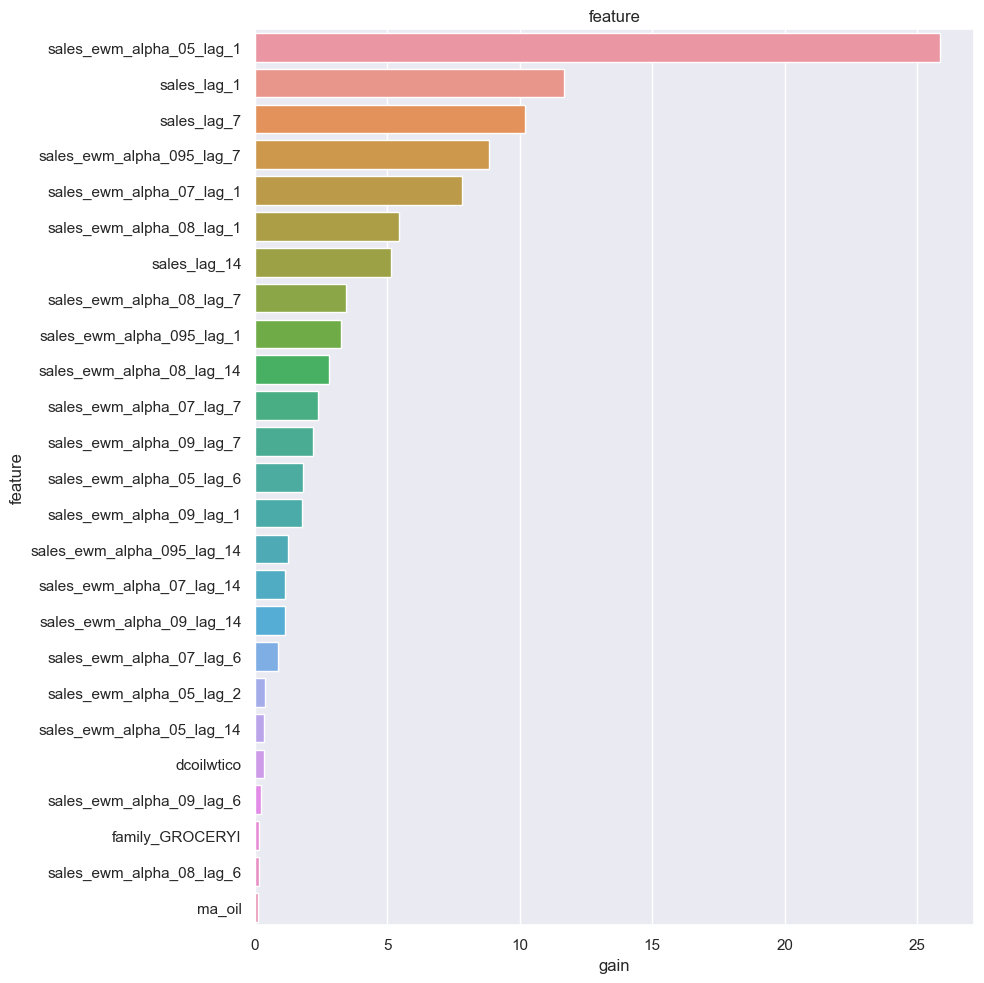

,feature,split,gain
86,sales_ewm_alpha_05_lag_1,110,25.858974
8,sales_lag_1,201,11.667883
14,sales_lag_7,195,10.188588
32,sales_ewm_alpha_095_lag_7,41,8.857443
71,sales_ewm_alpha_07_lag_1,57,7.806102
...,...,...,...
128,store_nbr_34,0,0.000000
127,store_nbr_33,0,0.000000
126,store_nbr_32,0,0.000000
125,store_nbr_31,0,0.000000


In [46]:
plot_lgb_importances(model_smape, num=30, plot=True)

In [47]:
rlsme(y_pred_val_rlsme, Y_val)

(1.0059372213624551,)

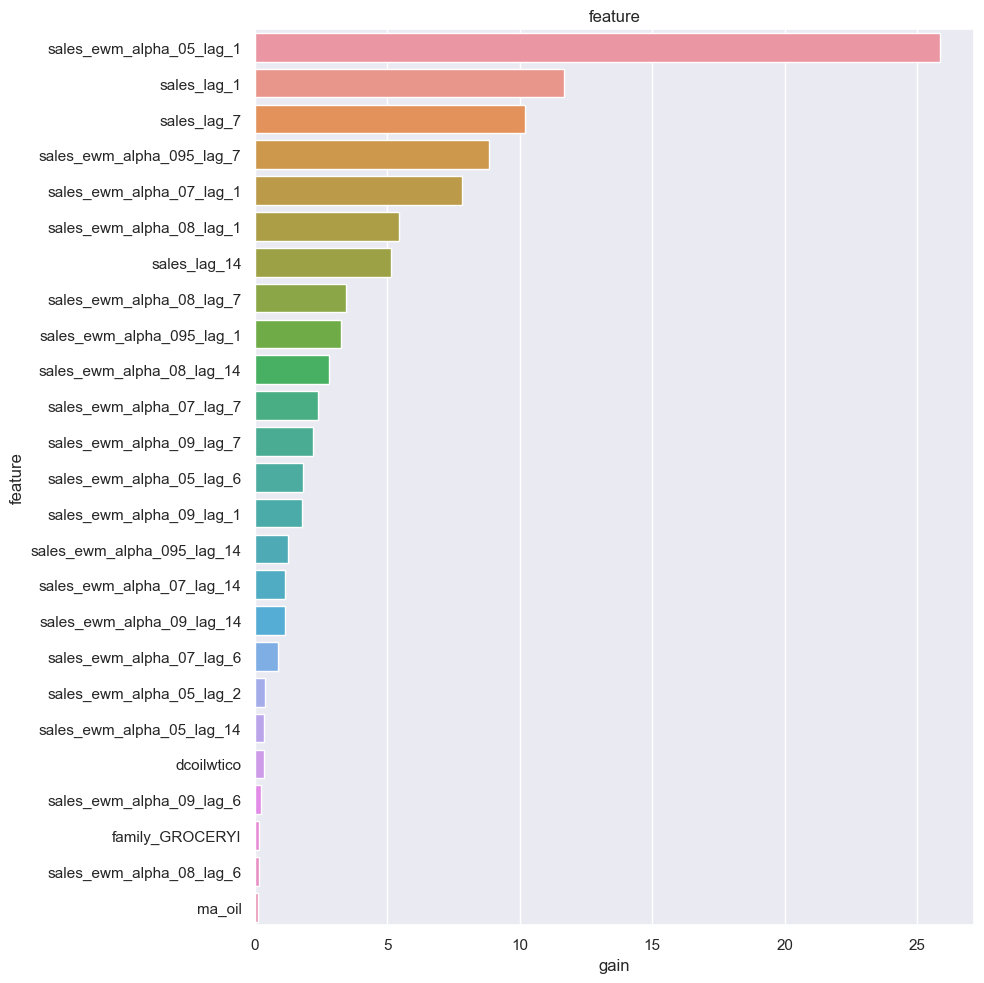

,feature,split,gain
86,sales_ewm_alpha_05_lag_1,110,25.854877
8,sales_lag_1,202,11.666205
14,sales_lag_7,197,10.188044
32,sales_ewm_alpha_095_lag_7,41,8.856039
71,sales_ewm_alpha_07_lag_1,57,7.804865
...,...,...,...
128,store_nbr_34,0,0.000000
127,store_nbr_33,0,0.000000
126,store_nbr_32,0,0.000000
125,store_nbr_31,0,0.000000


In [48]:
plot_lgb_importances(model_rlsme, num=30, plot=True)

In [49]:
feat_imp_rmsle = plot_lgb_importances(model_rlsme, num=200)

low_importance_rmsle = feat_imp_rmsle[feat_imp_rmsle["gain"] <= 0.005]["feature"].values

dff = df.drop(low_importance_rmsle, axis=1)

cols_dff = [col for col in dff.columns if col not in ['date', "sales", "year"]]

                       feature  split       gain
86    sales_ewm_alpha_05_lag_1    110  25.854877
8                  sales_lag_1    202  11.666205
14                 sales_lag_7    197  10.188044
32   sales_ewm_alpha_095_lag_7     41   8.856039
71    sales_ewm_alpha_07_lag_1     57   7.804865
..                         ...    ...        ...
155          family_AUTOMOTIVE      0   0.000000
154                store_nbr_9      0   0.000000
153                store_nbr_8      0   0.000000
152                store_nbr_7      0   0.000000
151                store_nbr_6      0   0.000000

[200 rows x 3 columns]


In [54]:
train = dff.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols_dff]


test = dff.loc[df.date >= "2017-07-31"]
X_test = test[cols_dff]
X_test.sales = np.nan

Y_train.shape, X_train.shape, X_test.shape

((3000888,), (3000888, 65), (28512, 65))

In [51]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model_rlsme.best_iteration}

In [52]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols_dff)

In [53]:
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model_rlsme.best_iteration)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [55]:
test_preds = final_model.predict(X_test, num_iteration=model_rlsme.best_iteration)

In [56]:
test_preds

array([10.46076187, 10.46076187, 10.46076187, ..., 19.08071914,
       20.52202662, 18.6106242 ])